In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import itertools
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

In [2]:
# Random seed
random_seed = 42
def set_random_seed(seed=42):
    np.random.seed(seed)
set_random_seed(random_seed)

## Models definition

### LightGBM

In [ ]:
import lightgbm as lgb


def train_lightgbm(train, valid, test, target_feature, n_classes):
    
    #train, valid, test = get_data_splits(df)
    
    feature_cols = train.columns.drop(target_feature)
    
    dtrain = lgb.Dataset(train[feature_cols], label=train[target_feature])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid[target_feature])

    param = {'num_leaves': 64, 'objective': 'multiclass', 
             'metric': 'multi_logloss', 'num_class': n_classes, 'seed': random_seed}
    
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    test_pred = bst.predict(test[feature_cols])
    test_pred = np.argmax(test_pred, axis=1)
    
    test_accuracy = metrics.accuracy_score(test[target_feature], test_pred)
    test_f1score = metrics.f1_score(test[target_feature], test_pred)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test f1 score: {test_f1score:.4f}")

    return bst

def train_lgbm_for_test(train, test, target_feature, n_classes):
    
    train, valid = get_train_valid_split(train)
    
    feature_cols = train.columns.drop(target_feature)

    dtrain = lgb.Dataset(train[feature_cols], label=train[target_feature])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid[target_feature])

    param = {'num_leaves': 64, 'objective': 'multiclass', 
             'metric': 'multi_logloss', 'num_class': n_classes, 'seed': random_seed}
    
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)
    
    test_pred = bst.predict(test)
    test_pred = np.argmax(test_pred, axis=1)
    test_pred = test_pred+1
    return test_pred

def new_features(df, cat_features):
    interactions = pd.DataFrame(index=df.index)

    # Iterate through each pair of features, combine them into interaction features
    for feature1, feature2 in itertools.combinations(cat_features, 2):
        interaction_feature = feature1+'_'+feature2
        interactions[interaction_feature] = preprocessing.LabelEncoder().fit_transform(df[feature1].apply(str)+'_'+df[feature2].apply(str))
    
    return interactions, list(interactions.columns)

### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

def train_decisiontree(X_train, X_test, y_train, y_test):

    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
    clf.fit(X_train, y_train)

    test_pred = clf.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    
    # test_accuracy = metrics.accuracy_score(y_test, test_pred)
    # test_f1score = metrics.f1_score(y_test, test_pred)
    # print(f"Test accuracy: {test_accuracy:.4f}")
    # print(f"Test f1 score: {test_f1score:.4f}")

    return clf

### MLP

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

def train_MLPClassifier(X_train, X_test, y_train, y_test):
       
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)    
    
    print("Training model!")
    est = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 10 ), activation='relu', solver='adam', alpha=0.0001, 
                       batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                       power_t=0.5, max_iter=40, shuffle=True, random_state=None, tol=0.0001, 
                       verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                       early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                       epsilon=1e-08, n_iter_no_change=10)
    
    est.fit(X_train, y_train)
    
    print(f"Test accuracy score: {est.score(X_test, y_test):.4f}")

    return est

#train, valid = train_test_split(X_y, 0.2)
#est = train_MLPRegressor(train, valid, 'damage_grade')

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

def train_randomforest(X_train, X_test, y_train, y_test):

    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    clf.fit(X_train, y_train)

    test_pred = clf.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    
    # test_accuracy = metrics.accuracy_score(y_test, test_pred)
    # test_f1score = metrics.f1_score(y_test, test_pred)
    # print(f"Test accuracy: {test_accuracy:.4f}")
    # print(f"Test f1 score: {test_f1score:.4f}")

    return clf

## Data import and preparation

In [10]:
DATA_ROOT = '../data/processed'

In [11]:
df = pd.read_csv(f'{DATA_ROOT}/bugs-multitarget.csv')
df['priority'] = df['priority'].astype(int)
df.head()

,commitHash,inMainBranch,merge,classes,functions,commentLines,commentLinesDensity,complexity,fileComplexity,classComplexity,...,vulnerabilities,reliabilityRemediationEffort,reliabilityRating,securityRemediationEffort,securityRating,wontFixIssues,packageDependencyCycles,entropylike,added/total_lines,priority
0,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,3
1,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,4
2,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,4
3,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,5
4,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,5


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

N_CLASSES = 6
common_cols = list(df.columns)
common_cols.remove('priority')


mlb = MultiLabelBinarizer()
df = df.groupby(common_cols)['priority'].apply(set).reset_index()
df = shuffle(df)
df['priority'] = df['priority'].to_numpy()
y_raw = df['priority']
y_raw = y_raw.to_numpy()
y_raw = [np.array(list(x)) for x in y_raw]
y = mlb.fit_transform(df['priority'])
df.drop(['commitHash', 'priority'], axis=1, inplace=True)
X = df.to_numpy()
df.head()

,inMainBranch,merge,classes,functions,commentLines,commentLinesDensity,complexity,fileComplexity,classComplexity,functionComplexity,...,newSqaleDebtRatio,vulnerabilities,reliabilityRemediationEffort,reliabilityRating,securityRemediationEffort,securityRating,wontFixIssues,packageDependencyCycles,entropylike,added/total_lines
47107,True,False,204,1595,13130,39.5,3058,15.3,15.0,1.9,...,3.509381,147,55,4,3350,4,0,0,4,0.000334
27953,True,False,525,3235,16400,15.4,6474,12.8,12.2,1.9,...,2.801844,34,408,4,485,4,0,0,2,0.000057
11868,True,False,2069,12194,48909,26.2,24543,15.5,11.7,2.0,...,3.822500,275,3419,5,3350,4,0,0,1,0.000020
27520,True,False,388,3229,22876,48.2,6449,17.5,16.6,2.0,...,6.448011,59,707,5,755,4,0,0,1,0.000021
17786,True,False,184,1132,4405,25.1,2060,12.3,11.2,1.8,...,3.472683,70,0,1,1575,4,0,0,6,0.000338


In [13]:
X.shape

(54622, 54)

In [14]:
X[0]

array([True, False, 204, 1595, 13130, 39.5, 3058, 15.3, 15.0, 1.9, 0,
       1284, 45, 28, 2.8, 1775, 1, 233, 41, 0, 0, 1625, 3, 0, 0, 0, 2701,
       45120, 20103, 11073, 0, 842, 658, 1775, 1, 0, 36, 36, 8545, 11073,
       0, 22593, 603090, 3.7, 3.5093806875201987, 147, 55, 4, 3350, 4, 0,
       0, 4, 0.00033402922755741135], dtype=object)

In [15]:
y.shape

(54622, 6)

### Downsampling

In [16]:
nobug_idxs = []
all_idxs = []
for i, label in enumerate(y):
  all_idxs.append(i)
  if np.array_equal(label, [1, 0, 0, 0, 0, 0]):
    nobug_idxs.append(i)

print(len(nobug_idxs)/len(y))

0.9952583208231116


In [17]:
import random

D = 0.75
rm_idxs = random.sample(nobug_idxs, int(len(nobug_idxs)*D))
use_idxs = np.array(list(set(all_idxs) - set(rm_idxs)))
X = X[use_idxs]
y = y[use_idxs]


In [18]:
X.shape

(13850, 54)

In [19]:
y.shape


(13850, 6)

## Training & Evaluation

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Decision Tree

In [21]:
tree = train_decisiontree(X_train, X_test, y_train, y_test)

In [22]:
yPred = tree.predict(X_test)

In [23]:
yPred.sum(axis=0)

array([2708,    4,   37,    6,   38,    6])

In [24]:
y_test.sum(axis=0)

array([2714,    7,   27,   13,   49,   13])

### MLP

In [25]:
mlp = train_MLPClassifier(X_train, X_test, y_train, y_test)

Training model!
Test accuracy score: 0.9794


In [26]:
yPred = mlp.predict(X_test)

In [27]:
yPred.sum(axis=0)

array([2770,    0,    0,    0,    0,    0])

### Random Forest

In [28]:
rf = train_randomforest(X_train, X_test, y_train, y_test)


In [29]:
yPred = rf.predict(X_test)

In [30]:
yPred.sum(axis=0)

array([2760,    0,    4,    0,    5,    1])

## Results

In [31]:
def plot_confusion_matrix(clf, X, y):
    predY = clf.predict(X)
    cm = multilabel_confusion_matrix(y, predY)
    cms = []
    for i, m in enumerate(cm):
      cms.append(m / m.sum(axis=1)[:, np.newaxis])
      plt.subplot(len(cm)/2, 2, i+1)
      plt.tight_layout()
      plt.imshow(m / m.sum(axis=1)[:, np.newaxis])
      plt.title(f'Priority {i}')
    return cms

def get_accuracy(clf, X, y):
    accuracy = clf.score(X, y)
    print(accuracy)
    return accuracy

def get_bug_classification_accuracy(clf, X, y):
  yPreds = clf.predict(X)
  good = 0
  n = 0
  for i, yPred in enumerate(yPreds):
    for j, label in enumerate(yPred):
      if j > 0:
        n += 1
        if label == y[i, j]:
          good += 1
  acc = good / n
  print(acc)
  return acc

### Decision Tree

[array([[0.26785714, 0.73214286],
        [0.01731761, 0.98268239]]), array([[0.9985523, 0.0014477],
        [1.       , 0.       ]]), array([[0.98833394, 0.01166606],
        [0.81481481, 0.18518519]]), array([[0.99782372, 0.00217628],
        [1.        , 0.        ]]), array([[0.98934215, 0.01065785],
        [0.81632653, 0.18367347]]), array([[0.99818643, 0.00181357],
        [0.92307692, 0.07692308]])]

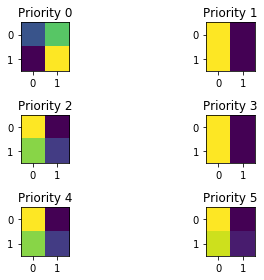

In [32]:
plot_confusion_matrix(tree, X_test, y_test)

In [33]:
get_accuracy(tree, X_test, y_test)
get_bug_classification_accuracy(tree, X_test, y_test)

0.9628158844765343
0.9877256317689531


0.9877256317689531

### MLP

[array([[0., 1.],
        [0., 1.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]])]

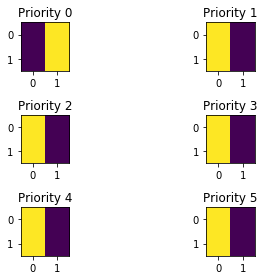

In [34]:
plot_confusion_matrix(mlp, X_test, y_test)

In [35]:
get_accuracy(mlp, X_test, y_test)
get_bug_classification_accuracy(mlp, X_test, y_test)

0.9794223826714802
0.9921299638989169


0.9921299638989169

### Random Forest

[array([[0.08928571, 0.91071429],
        [0.0018423 , 0.9981577 ]]), array([[1., 0.],
        [1., 0.]]), array([[9.99270871e-01, 7.29128691e-04],
        [9.25925926e-01, 7.40740741e-02]]), array([[1., 0.],
        [1., 0.]]), array([[0.99852995, 0.00147005],
        [0.97959184, 0.02040816]]), array([[9.99637287e-01, 3.62713094e-04],
        [1.00000000e+00, 0.00000000e+00]])]

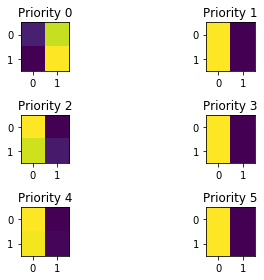

In [36]:
plot_confusion_matrix(rf, X_test, y_test)

In [37]:
get_accuracy(rf, X_test, y_test)
get_bug_classification_accuracy(rf, X_test, y_test)

0.9776173285198556
0.991841155234657


0.991841155234657

## Save Models

In [102]:
import pickle

In [104]:
pickle.dump(tree, open('../models/tree.sav', 'wb'))
pickle.dump(mlp, open('../models/mlp.sav', 'wb'))
pickle.dump(rf, open('../models/rf.sav', 'wb'))